In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset

In [ ]:
# 데이터 로드 함수
def load_data(file_path):
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'])
    data['label'] = data['label'].map({'pos': 1, 'neg': 0})  # 긍정: 1, 부정: 0
    return data

In [ ]:
# 데이터셋 로드
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")

# 데이터셋 정보 출력
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [ ]:
from transformers import BertTokenizer

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 토크나이저를 사용하여 텍스트를 전처리
def tokenize_data(example):
    return tokenizer(example['text'], truncation=True, padding="max_length", max_length=512)

# 모든 데이터셋에 토크나이저 적용
tokenized_datasets = dataset.map(tokenize_data, batched=True)

# PyTorch 또는 TensorFlow 데이터셋으로 변환 가능
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# BERT 모델 초기화 (감정 분류를 위해 num_labels=3 설정)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 학습 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 학습 시작
trainer.train()

# 테스트 데이터셋 평가
results = trainer.evaluate(test_dataset)
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.411400,0.332562
2,0.195700,0.489895
3,0.080700,0.657881


{'eval_loss': 0.721571147441864, 'eval_runtime': 33.6932, 'eval_samples_per_second': 31.638, 'eval_steps_per_second': 1.989, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 테스트 데이터셋 예측
predictions = trainer.predict(test_dataset)

# 로짓 값을 확률로 변환 후, 가장 높은 값의 인덱스가 예측 레이블
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8480
Precision: 0.8482
Recall: 0.8480
F1-score: 0.8480


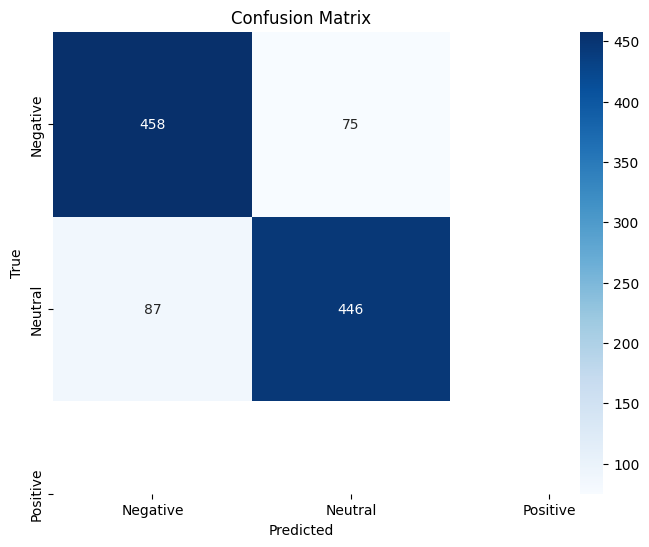

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)
classes = ["Negative", "Neutral", "Positive"]

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 실패 사례 확인
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:  # 잘못된 예측
        print(f"Text: {test_dataset['text'][i]}")
        print(f"True Label: {classes[y_true[i]]}, Predicted Label: {classes[y_pred[i]]}")
        print("-" * 50)


Text: it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .
True Label: Neutral, Predicted Label: Negative
--------------------------------------------------
Text: weighty and ponderous but every bit as filling as the treat of the title .
True Label: Neutral, Predicted Label: Negative
--------------------------------------------------
Text: mostly , [goldbacher] just lets her complicated characters be unruly , confusing and , through it all , human .
True Label: Neutral, Predicted Label: Negative
--------------------------------------------------
Text: at its worst , the movie is pretty diverting ; the pity is that it rarely achieves its best .
True Label: Neutral, Predicted Label: Negative
--------------------------------------------------
Text: making such a tragedy the backdrop to a love story risks trivializing it , though chouraqui no doubt intended the film to affirm love's power to help people endur

In [ ]:
# 모델 및 토크나이저 저장
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

# 저장된 모델 로드 (재사용 예시)
from transformers import BertForSequenceClassification, BertTokenizer
loaded_model = BertForSequenceClassification.from_pretrained("./sentiment_model")
loaded_tokenizer = BertTokenizer.from_pretrained("./sentiment_model")


In [ ]:
# 새로운 텍스트 감정 분석 함수
def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    predicted_label = sentiment_labels[probabilities.argmax()]
    return predicted_label, probabilities.detach().numpy()

# 테스트 텍스트
text = "Who wrote this stuff. Waste of my time. Bad actors bad story."
predicted_label, probabilities = predict_sentiment(text, loaded_model, loaded_tokenizer)
print(f"Predicted Sentiment: {predicted_label}")
print(f"Probabilities: {probabilities}")


Predicted Sentiment: Negative
Probabilities: [[9.9919087e-01 6.1498093e-04 1.9410075e-04]]
